In [1]:
import numpy as np
import graphtools
import tasklogger
from collections import defaultdict
from scipy.spatial.distance import pdist, cdist, squareform
import sklearn
import vne
import warnings

warnings.simplefilter("ignore")
import collections

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
### Diffusion Condensation Package

<IPython.core.display.Javascript object>

In [30]:
class CATCH(object):
    def __init__(
        self,
        knn=5,
        n_pca=50,
        t="auto",
        granularity=1,
        scale=1.025,
        t_max=50,
        n_jobs=1,
        random_state=None,
    ):

        self.scale = scale
        self.knn = knn
        self.n_pca = n_pca
        self.t = t
        self.granularity = granularity
        self.t_max = t_max
        self.n_jobs = n_jobs
        self.random_state = random_state

        self.NxTs = None
        self.Xs = None
        self.Ks = None
        self.merges = None
        self.Ps = None
        self.data_pca = None
        self.pca_op = None
        self.epsilon = None
        self.merge_threshold = None
        self.gradient = None
        self.levels = None
        self.ind_components = None
        self.gradient = None

        super().__init__()

    def fit(self, data):
        (
            self.data_pca,
            self.NxTs,
            self.Xs,
            self.merges,
            self.Ps,
            self.pca_op,
            self.epsilon,
            self.merge_threshold,
        ) = condensation(
            data,
            knn=self.knn,
            n_pca=self.n_pca,
            t=self.t,
            granularity=self.granularity,
            scale=self.scale,
            t_max=self.t_max,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
        )

    def transform(self):
        with tasklogger.log_task("Topological Activity"):
            ind_components = []

            for c in range(len(self.NxTs)):
                ind_components.append(len(np.unique(self.NxTs[c])))
            self.ind_components = np.array(ind_components)
            self.gradient = np.diff(np.log(self.ind_components))
            locs = np.where(self.gradient == 0)[0]
            res = []
            for c in range(1, len(locs)):
                if ind_components[locs[c]] - ind_components[locs[c - 1]] != 0:
                    res.append(locs[c])
            self.levels = np.array(res) - len(self.NxTs)
        return self.levels

    def fit_transform(self, data):
        self.fit(data)
        return self.transform()

<IPython.core.display.Javascript object>

In [4]:
# powered condensation
def comp(node, neigh, visited):
    """Short summary.
    Parameters
    ----------
    node : type
        Description of parameter `node`.
    neigh : type
        Description of parameter `neigh`.
    visited : type
        Description of parameter `visited`.
    Returns
    -------
    type
        Description of returned object.
    """
    vis = visited.add
    nodes = set([node])
    next_node = nodes.pop
    while nodes:
        node = next_node()
        vis(node)
        nodes |= neigh[node] - visited
        yield node


def merge_common(lists):
    """Short summary.
    Parameters
    ----------
    lists : type
        Description of parameter `lists`.
    Returns
    -------
    type
        Description of returned object.
    """
    neigh = collections.defaultdict(set)
    visited = set()
    for each in lists:
        for item in each:
            neigh[item].update(each)
    for node in neigh:
        if node not in visited:
            yield sorted(comp(node, neigh=neigh, visited=visited))


def compute_optimal_t(diff_op, t_max):
    t = np.arange(t_max)
    h = vne.compute_von_neumann_entropy(diff_op, t_max=t_max)
    return vne.find_knee_point(y=h, x=t)


def compress_data(X, n_pca=50, random_state=None):
    pca_op = sklearn.decomposition.PCA(n_components=n_pca, random_state=random_state)
    return pca_op.fit_transform(X), pca_op


def condense_vne_adaptive(X, knn=5, n_jobs=1, t="auto", t_max=50, random_state=None):
    if X.shape[0] > 2000:
        n_landmarks = 1000
    else:
        n_landmarks = None
    G = graphtools.Graph(
        X,
        n_pca=None,
        knn=min(X.shape[0] - 2, knn),
        n_jobs=n_jobs,
        n_landmark=n_landmarks,
        random_state=random_state,
    )

    P_s = G.P.toarray()
    if n_landmarks == None:
        if t == "auto" and t_max > 2:
            t = compute_optimal_t(P_s, t_max)
        # print(t)
        P_s = np.linalg.matrix_power(P_s, t)
        return P_s @ X, P_s, G.K.toarray(), t
    else:
        if t == "auto" and t_max > 2:
            t = compute_optimal_t(G.landmark_op, t_max)
        # print(t)
        G_pl = G.transitions
        G_lp = G._data_transitions()
        P_s = G_pl @ np.linalg.matrix_power(G.landmark_op, t) @ G_lp
        return P_s @ X, P_s, G.K.toarray(), t


def condense_fixed(X, epsilon, t_max=10, n_jobs=1, random_state=None):
    if X.shape[0] > 5000:
        n_landmarks = 1000
    else:
        n_landmarks = None
    G = graphtools.Graph(
        X,
        n_pca=None,
        bandwidth=epsilon,
        n_jobs=n_jobs,
        n_landmark=n_landmarks,
        random_state=random_state,
    )

    if n_landmarks == None:
        P_s = G.P.toarray()
        t = compute_optimal_t(P_s, 10)
        P_s = np.linalg.matrix_power(P_s, t_max)
        return P_s @ X, P_s, G.K.toarray()
    else:
        G_pl = G.transitions
        G_lp = G._data_transitions()
        P_s = G.landmark_op
        t = compute_optimal_t(P_s, t_max)
        # print("t: "+str(t))
        P_s = G_pl @ np.linalg.matrix_power(P_s, t) @ G_lp
        return P_s @ X, P_s, G.K.toarray()


def compute_merges(X, merge_threshold, n_jobs=1):
    D = pdist(X, metric="euclidean")
    D = squareform(D)

    bool_ = D < merge_threshold
    loc = np.where(bool_)
    merge_pairs = []
    for i in range(len(loc[0])):
        if loc[0][i] != loc[1][i]:
            merge_pairs.append(tuple([loc[0][i], loc[1][i]]))
    return merge_pairs


def compute_merge_threshold(X, n_jobs=1):
    """Short summary.
    Parameters
    ----------
    X : type
        Description of parameter `X`.
    granularity : type
        Description of parameter `granularity`.
    Returns
    -------
    type
        Description of returned object.
    """
    D = pdist(X, metric="euclidean")
    merge_threshold = np.percentile(D, 0.0001) + 1e-7
    return merge_threshold


# powered condensation
def comp(node, neigh, visited):
    """Short summary.
    Parameters
    ----------
    node : type
        Description of parameter `node`.
    neigh : type
        Description of parameter `neigh`.
    visited : type
        Description of parameter `visited`.
    Returns
    -------
    type
        Description of returned object.
    """
    vis = visited.add
    nodes = set([node])
    next_node = nodes.pop
    while nodes:
        node = next_node()
        vis(node)
        nodes |= neigh[node] - visited
        yield node


def merge_common(lists):
    """Short summary.
    Parameters
    ----------
    lists : type
        Description of parameter `lists`.
    Returns
    -------
    type
        Description of returned object.
    """
    neigh = collections.defaultdict(set)
    visited = set()
    for each in lists:
        for item in each:
            neigh[item].update(each)
    for node in neigh:
        if node not in visited:
            yield sorted(comp(node, neigh=neigh, visited=visited))


def condensation(
    data,
    knn=5,
    n_pca=50,
    t="auto",
    granularity=1,
    scale=1.025,
    t_max=50,
    n_jobs=1,
    random_state=None,
):
    if n_pca != None and data.shape[0] > n_pca:
        with tasklogger.log_task("PCA"):
            X, pca_op = compress_data(data, n_pca=n_pca, random_state=random_state)
    else:
        X = data

    N = X.shape[0]
    NxT = []
    clusters = np.arange(N)
    NxT.append(clusters)
    NxT.append(clusters)

    X_1 = X.copy()
    K_list = []
    X_list = []
    X_list.append(X_1)
    X_list.append(X_1)
    P_list = []
    merged = []

    with tasklogger.log_task("Diffusion Condensation"):
        X_2, P_s, K_2, t_max = condense_vne_adaptive(
            X_1, knn=knn, t=t, t_max=t_max, n_jobs=n_jobs, random_state=random_state
        )
        X_list.append(X_1)
        P_list.append(P_s)
        NxT.append(NxT[-1].copy())
        K_list.append(K_2)

        with tasklogger.log_task("Condensation Parameters"):
            merge_threshold = compute_merge_threshold(X_2, n_jobs=n_jobs)

            merge_pairs = compute_merges(X_2, merge_threshold, n_jobs=n_jobs)
            merge_pairs = list(merge_common(merge_pairs))
            # print(len(merge_pairs))
            merged.append(merge_pairs)

            X_1, cluster_assignment = complete_merges(X_2, merge_pairs, NxT[-1])

            epsilon = (
                granularity * (0.1 * np.mean(np.std(X_1))) / (X_1.shape[0] ** (-1 / 5))
            )

            del X_list[-1]
            X_list.append(X_1)
            del NxT[-1]
            NxT.append(cluster_assignment)

        while X_1.shape[0] > 1:
            epsilon = epsilon * scale
            _, weights = np.unique(cluster_assignment, return_counts=True)

            X_2, P_s, K_2 = condense_fixed_weighted(
                X_1,
                weights=weights,
                epsilon=epsilon,
                t_max=t_max,
                n_jobs=n_jobs,
                random_state=random_state,
            )

            X_list.append(X_1)
            P_list.append(P_s)
            NxT.append(NxT[-1].copy())
            K_list.append(K_2)

            merge_pairs = compute_merges(X_2, merge_threshold, n_jobs=n_jobs)
            merge_pairs = list(merge_common(merge_pairs))
            merged.append(merge_pairs)

            X_1, cluster_assignment = complete_merges(X_2, merge_pairs, NxT[-1])

            del X_list[-1]
            X_list.append(X_1)
            del NxT[-1]
            NxT.append(cluster_assignment)

    if n_pca != None and data.shape[0] > n_pca:
        return X, NxT, X_list, merged, P_list, pca_op, epsilon, merge_threshold

    else:
        return X, NxT, X_list, merged, P_list, None, epsilon, merge_threshold


def complete_merges(X_1, merge_pairs, cluster_assignment):
    clusters_uni = np.unique(cluster_assignment)
    to_delete = []
    for m in range(len(merge_pairs)):
        to_merge = merge_pairs[m]
        X_1[to_merge[0]] = np.mean(X_1[to_merge], axis=0)
        to_delete.extend(to_merge[1:])
        for c in to_merge[1:]:
            cluster_assignment[
                cluster_assignment == clusters_uni[c]
            ] = cluster_assignment[clusters_uni[to_merge[0]]]
    X_1 = np.delete(X_1, to_delete, axis=0)
    return X_1, cluster_assignment


def condense_fixed_weighted(X, weights, epsilon, t_max=10, n_jobs=1, random_state=None):

    G_1 = graphtools.Graph(
        X,
        n_pca=None,
        bandwidth=epsilon,
        n_jobs=n_jobs,
        n_landmark=None,
        random_state=random_state,
    )

    K = weights * G_1.K.toarray()

    if X.shape[0] > 5000:
        n_landmarks = 1000
    else:
        n_landmarks = None

    G = graphtools.Graph(
        K,
        precomputed="affinity",
        bandwidth=epsilon,
        n_jobs=n_jobs,
        n_landmark=n_landmarks,
        random_state=random_state,
    )

    if n_landmarks == None:
        P_s = G.P
        t = compute_optimal_t(P_s, t_max)
        P_s = np.linalg.matrix_power(P_s, t)
        return P_s @ X, P_s, K
    else:
        G_pl = G.transitions
        G_lp = G._data_transitions()
        P_s = G.landmark_op
        t = compute_optimal_t(P_s, t_max)
        # print("t: "+str(t))
        P_s = G_pl @ np.linalg.matrix_power(P_s, t) @ G_lp
        return P_s @ X, P_s, K

<IPython.core.display.Javascript object>

In [5]:
### downloading data

<IPython.core.display.Javascript object>

In [6]:
import pandas as pd
import numpy as np

<IPython.core.display.Javascript object>

In [7]:
data = pd.read_pickle("/home/mkuchroo/temp_data/pbmc_4k_sqrt.pickle")

<IPython.core.display.Javascript object>

In [8]:
import phate

phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data)

Calculating PHATE...
  Running PHATE on 4360 cells and 15404 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 26.04 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.83 seconds.
    Calculating affinities...
    Calculated affinities in 0.24 seconds.
  Calculated graph and diffusion operator in 34.21 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.46 seconds.
    Calculating KMeans...
    Calculated KMeans in 13.91 seconds.
  Calculated landmark operator in 15.34 seconds.
  Calculating optimal t...
  Calculated optimal t in 3.63 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.66 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.46 seconds.
Calculated PHATE in 59.31 seconds.


<IPython.core.display.Javascript object>

In [9]:
### Running CATCH

<IPython.core.display.Javascript object>

In [31]:
catch_op = CATCH(knn=10, random_state=1, n_pca=25, n_jobs=5)

<IPython.core.display.Javascript object>

In [32]:
catch_op.fit(data)

Calculating PCA...
Calculated PCA in 15.43 seconds.
Calculating Diffusion Condensation...
  Calculating Condensation Parameters...
  Calculated Condensation Parameters in 3.16 seconds.
Calculated Diffusion Condensation in 67.50 seconds.


<IPython.core.display.Javascript object>

In [33]:
levels = catch_op.transform()

Calculating Topological Activity...


<IPython.core.display.Javascript object>

In [35]:
levels

array([-105,  -99,  -95,  -86,  -80,  -78,  -76,  -72,  -70,  -65,  -61,
        -56,  -53,  -46,  -35,  -31,  -26,  -21,  -18,  -10])

<IPython.core.display.Javascript object>

In [34]:
len(catch_op.NxTs)

113

<IPython.core.display.Javascript object>

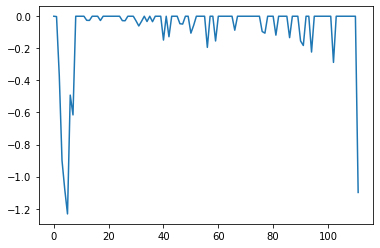

<IPython.core.display.Javascript object>

In [38]:
import matplotlib.pyplot as plt

plt.plot(catch_op.gradient)

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

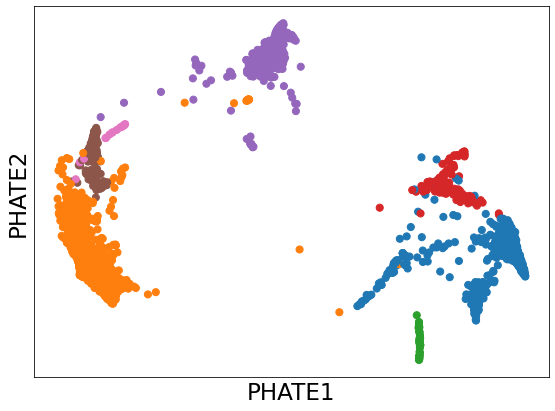

<IPython.core.display.Javascript object>

In [37]:
import scprep

scprep.plot.scatter2d(
    data_phate,
    c=catch_op.NxTs[levels[-4]],
    fontsize=16,
    s=50,
    legend=False,
    ticks=False,
    label_prefix="PHATE",
    figsize=(8, 6),
)

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

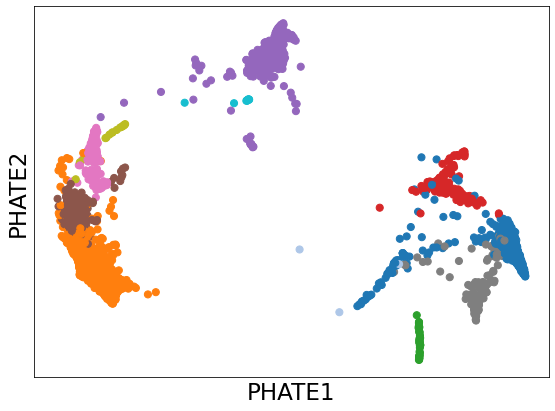

<IPython.core.display.Javascript object>

In [40]:
scprep.plot.scatter2d(
    data_phate,
    c=catch_op.NxTs[levels[-7]],
    fontsize=16,
    s=50,
    legend=False,
    ticks=False,
    label_prefix="PHATE",
    figsize=(8, 6),
)